In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
df = pd.read_csv("./data_baru/new_data.csv")
df

,Unnamed: 0,number_of_dependents,net_income,loan_amount,amount_of_late,late_payment_amount,credit_score,arrears_amounts,aset,tenor,debtor_education_level,aging,loss_reverse
0,0,3.0,15500000.0,6.250000e+07,2.0,1.0,670.0,0.0,11000000.0,21.0,D3,DPK,0.000000e+00
1,1,3.0,17500000.0,7.083333e+07,31.0,3.0,402.0,1.0,17000000.0,18.0,D3,DPK,1.770833e+07
2,2,4.0,17500000.0,5.933333e+07,0.0,0.0,505.0,0.0,14500000.0,17.0,D2,Lancar,0.000000e+00
3,3,3.0,15500000.0,6.116667e+07,64.0,5.0,508.0,1.0,11500000.0,17.0,D2,DPK,1.529167e+07
4,4,5.0,8700000.0,5.616667e+07,14.0,2.0,371.0,0.0,5500000.0,15.0,SMA,DPK,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,4.0,15500000.0,8.800000e+07,106.0,7.0,272.0,2.0,15000000.0,10.0,D3,Kurang lancar,4.400000e+07
4996,4996,4.0,19000000.0,5.100000e+07,25.0,1.0,464.0,1.0,9500000.0,17.0,S1,DPK,1.275000e+07
4997,4997,6.0,12700000.0,6.150000e+07,53.0,4.0,369.0,1.0,11500000.0,7.0,SMA,DPK,1.537500e+07
4998,4998,6.0,13700000.0,5.900000e+07,27.0,1.0,266.0,1.0,6500000.0,12.0,SMA,DPK,1.475000e+07


In [3]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   number_of_dependents    5000 non-null   float64
 1   net_income              5000 non-null   float64
 2   loan_amount             5000 non-null   float64
 3   amount_of_late          5000 non-null   float64
 4   late_payment_amount     5000 non-null   float64
 5   credit_score            5000 non-null   float64
 6   arrears_amounts         5000 non-null   float64
 7   aset                    5000 non-null   float64
 8   tenor                   5000 non-null   float64
 9   debtor_education_level  5000 non-null   object 
 10  aging                   5000 non-null   object 
 11  loss_reverse            5000 non-null   float64
dtypes: float64(10), object(2)
memory usage: 468.9+ KB


In [5]:
for i in df.columns:
    if df[i].dtype == "object":
        df[i] = df[i].astype("category")
        


In [6]:
columns = {}
for i in df.columns:
    if df[i].dtype == "category" or df[i].dtype == "object":
        columns[i] = LabelEncoder().fit(df[i])
        df[i] = columns[i].transform(df[i])

y = df["loss_reverse"]
df.drop("loss_reverse", axis=1, inplace=True)
scaler = RobustScaler().fit(df[[i for i in df.columns if i not in columns]])
df2 = pd.DataFrame(scaler.transform(df[[i for i in df.columns if i not in columns]]), columns=df[[i for i in df.columns if i not in columns]].columns)
for i in columns:
    df2[i] = df[i]
df2.head(5)

,number_of_dependents,net_income,loan_amount,amount_of_late,late_payment_amount,credit_score,arrears_amounts,aset,tenor,debtor_education_level,aging
0,0.0,0.000000,0.190476,-0.800000,-0.6,1.589041,-1.0,0.6,0.909091,2,0
1,0.0,0.266667,0.984127,-0.413333,-0.2,0.365297,0.0,1.8,0.636364,2,0
2,0.5,0.266667,-0.111111,-0.826667,-0.8,0.835616,-1.0,1.3,0.545455,1,3
3,0.0,0.000000,0.063492,0.026667,0.2,0.849315,0.0,0.7,0.545455,1,0
4,1.0,-0.906667,-0.412698,-0.640000,-0.4,0.223744,-1.0,-0.5,0.363636,7,0


In [7]:
X = df2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 11), (1000, 11), (4000,), (1000,))

In [8]:
model = BaggingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mse ** (1/2)
r_square = r2_score(y_test, y_pred)

print(f"""
      Mean Squared Errror : {mse:.2f}
      Mean Absolute Error : {mae:.2f}
      Mean Absolute Percentage Error : {mape:.2f}
      Root Mean Squared Error : {mape:.2f}
      R_Squared : {r_square:.2f}
      """)


      Mean Squared Errror : 281257829861.11
      Mean Absolute Error : 85470.83
      Mean Absolute Percentage Error : 0.00
      Root Mean Squared Error : 0.00
      R_Squared : 1.00
      


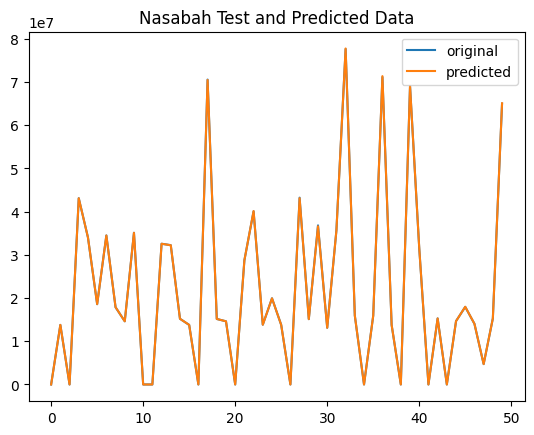

In [10]:
x_ax = range(len(y_test[:50]))
plt.plot(x_ax, y_test[:50], label="original")
plt.plot(x_ax, y_pred[:50], label="predicted")
plt.title("Nasabah Test and Predicted Data")
plt.legend()
plt.show()

In [11]:
y.describe()

count    5.000000e+03
mean     2.134012e+07
std      1.821149e+07
min      0.000000e+00
25%      1.358333e+07
50%      1.562500e+07
75%      3.041667e+07
max      1.785417e+08
Name: loss_reverse, dtype: float64

In [12]:
df2

,number_of_dependents,net_income,loan_amount,amount_of_late,late_payment_amount,credit_score,arrears_amounts,aset,tenor,debtor_education_level,aging
0,0.0,0.000000,0.190476,-0.800000,-0.6,1.589041,-1.0,0.6,0.909091,2,0
1,0.0,0.266667,0.984127,-0.413333,-0.2,0.365297,0.0,1.8,0.636364,2,0
2,0.5,0.266667,-0.111111,-0.826667,-0.8,0.835616,-1.0,1.3,0.545455,1,3
3,0.0,0.000000,0.063492,0.026667,0.2,0.849315,0.0,0.7,0.545455,1,0
4,1.0,-0.906667,-0.412698,-0.640000,-0.4,0.223744,-1.0,-0.5,0.363636,7,0
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.5,0.000000,2.619048,0.586667,0.6,-0.228311,1.0,1.4,-0.090909,2,2
4996,0.5,0.466667,-0.904762,-0.493333,-0.6,0.648402,0.0,0.3,0.545455,3,0
4997,1.5,-0.373333,0.095238,-0.120000,0.0,0.214612,0.0,0.7,-0.363636,7,0
4998,1.5,-0.240000,-0.142857,-0.466667,-0.6,-0.255708,0.0,-0.3,0.090909,7,0
